3220201026
郑慧娴
计算机学院
互评作业-3

# Hotel booking demand, 酒店预订需求
数据集：Hotel booking demand

该数据集包含城市酒店和度假酒店的预订信息，包括预订时间、停留时间，成人/儿童/婴儿人数以及可用停车位数量等信息。

数据量：32列共12W数据。

基于这个数据集，可进行以下问题的探索：

基本情况：城市酒店和假日酒店预订需求和入住率比较；
用户行为：提前预订时间、入住时长、预订间隔、餐食预订情况；
一年中最佳预订酒店时间；
利用Logistic预测酒店预订。
也可以自行发现其他问题，并进行相应的挖掘。

In [263]:
from pandas import Series,DataFrame
import numpy
from numpy import nan as NA
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 以下代码从全局设置字体为SimHei（黑体），解决显示中文问题【Windows】
# 设置font.sans-serif 或 font.family 均可
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决中文字体下坐标轴负数的负号显示问题
plt.rcParams['axes.unicode_minus'] = False 

In [264]:
# 加载数据
def load_data(path,filename):
    return pd.read_csv(path + '/' + filename)
root = 'C:/Users/hespe/Desktop/课件/数据挖掘'
data = load_data(root,'hotel_bookings.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


1. 数据预处理

In [249]:
print("原始数据集大小:")
print(data.shape)
data.isnull().sum()
print("每列缺失的数据个数分别为:")
print(data.isnull().sum())

原始数据集大小:
(119390, 32)
每列缺失的数据个数分别为:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                

载入原始数据集hotel_bookings.csv,该数据集包括119390条酒店预订记录,每条记录含32列(32个属性);
统计缺失值,结果显示children属性缺失的有4条记录,country属性缺失的有488条,agent属性缺失有16340条,company属性缺失有112593条.

接下来对数据进行预处理,包括缺失值的填充和异常值处理.
(1)用众数填充children缺失值
(2)为了后续对不同国家进行分析,删除country缺失的记录
(3)agent缺失即预订酒店不通过agent,将其设置为0
(4)company属性缺失记录过多,且杂乱,对于数据分析无意义,因此不对其进行处理
(5)计算每条记录中实际入住的人数总和,若实际入住人数=0,则认为是异常值,删除该条记录
(6)去除重复的记录

In [250]:
print("*众数填充children缺失值")
data['children'].fillna(data['children'].mode()[0],inplace=True)

print("*删除country缺失所在的行")
data=data.dropna(axis=0,subset=['country'])

print("*填充agent缺失 = 0 ")
data['agent'].fillna(0,inplace=True)

print("*处理异常值:删除adults+children+babies = 0 即入住总人数为0的数据行")
zero_people=list(
    data['adults']+
    data['children']+
    data['babies']==0
)
data.drop(data.index[zero_people],inplace=True)

print("*删除重复数据行,保留重复行的第一个")
df=data.drop_duplicates()

print("预处理后的数据集大小:")
print(df.shape)

*众数填充children缺失值
*删除country缺失所在的行
*填充agent缺失 = 0 
*处理异常值:删除adults+children+babies = 0 即入住总人数为0的数据行
*删除重复数据行,保留重复行的第一个
预处理后的数据集大小:
(86783, 32)


2. 数据集探索
(1)不同酒店类型预定需求和入住率比较

In [251]:
# 统计不同酒店预定的频数
# 统计不同酒店取消预定和真实入住的频数
rh_all_count=df[df["hotel"]=="Resort Hotel"].groupby('hotel')['hotel'].count()
ch_all_count=df[df["hotel"]=="City Hotel"].groupby('hotel')['hotel'].count()
rh_iscancel_count = df[df["hotel"]=="Resort Hotel"].groupby(["is_canceled"])["is_canceled"].count()
ch_iscancel_count = df[df["hotel"]=="City Hotel"].groupby(["is_canceled"])["is_canceled"].count()

print(rh_all_count)
print(ch_all_count)
print(rh_iscancel_count)
print(ch_iscancel_count)

hotel
Resort Hotel    33512
Name: hotel, dtype: int64
hotel
City Hotel    53271
Name: hotel, dtype: int64
is_canceled
0    25566
1     7946
Name: is_canceled, dtype: int64
is_canceled
0    37237
1    16034
Name: is_canceled, dtype: int64


In [252]:
import pyecharts.options as opts
from pyecharts.charts import Pie

inner_x_data = ["Resort Hotel度假酒店", "City Hotel城市酒店"]
inner_y_data = [33512, 53271]
inner_data_pair = [list(z) for z in zip(inner_x_data, inner_y_data)]

outer_x_data = ["度假酒店-取消", "度假酒店-入住", "城市酒店-取消", "城市酒店-入住"]
outer_y_data = [25566, 7946, 37237, 16034]
outer_data_pair = [list(z) for z in zip(outer_x_data, outer_y_data)]

(       
    Pie(init_opts=opts.InitOpts(width="1600px", height="800px"))
    .add(
        series_name="酒店分类",
        data_pair=inner_data_pair,
        radius=[0, "30%"],
        label_opts=opts.LabelOpts(position="inner"),
    )
    .add(
        series_name="是否入住",
        radius=["40%", "55%"],
        data_pair=outer_data_pair,
        label_opts=opts.LabelOpts(
            position="outside",
            formatter="{a|{a}}{abg|}\n{hr|}\n {b|{b}: }{c}  {per|{d}%}  ",
            background_color="#eee",
            border_color="#aaa",
            border_width=1,
            border_radius=4,
            rich={
                "a": {"color": "#999", "lineHeight": 22, "align": "center"},
                "abg": {
                    "backgroundColor": "#e3e3e3",
                    "width": "100%",
                    "align": "right",
                    "height": 22,
                    "borderRadius": [4, 4, 0, 0],
                },
                "hr": {
                    "borderColor": "#aaa",
                    "width": "100%",
                    "borderWidth": 0.5,
                    "height": 0,
                },
                "b": {"fontSize": 16, "lineHeight": 33},
                "per": {
                    "color": "#eee",
                    "backgroundColor": "#334455",
                    "padding": [2, 4],
                    "borderRadius": 2,
                },
            },
        ),
    )
    .set_global_opts(legend_opts=opts.LegendOpts(pos_left="left", orient="vertical"))
    .set_series_opts(
        tooltip_opts=opts.TooltipOpts(
            trigger="item", formatter="{a} <br/>{b}: {c} ({d}%)"
        )
    )
    .render("预订需求与入住率比较.html")
)

'C:\\Users\\hespe\\Desktop\\课件\\数据挖掘\\预订需求与入住率比较.html'

由于 pyecharts 输出的结果图HTML形式,为了便于查看,下面放一张结果图的截图:
![jupyter](./不同酒店预定需求与入住率对比图.PNG)
根据统计结果,城市酒店预定总数占61.38%,度假酒店预订总数占38.62%,城市酒店预定需求更高.
城市酒店和度假酒店实际入住数均低于取消数,城市酒店实际入住率为30.09%,度假酒店实际入住率为23.72%,城市酒店入住率稍高.

(2) 用户行为：提前预订时间、入住时长、餐食预订情况、酒店分布地区

Text(0, 0.5, '取消数 [%]')

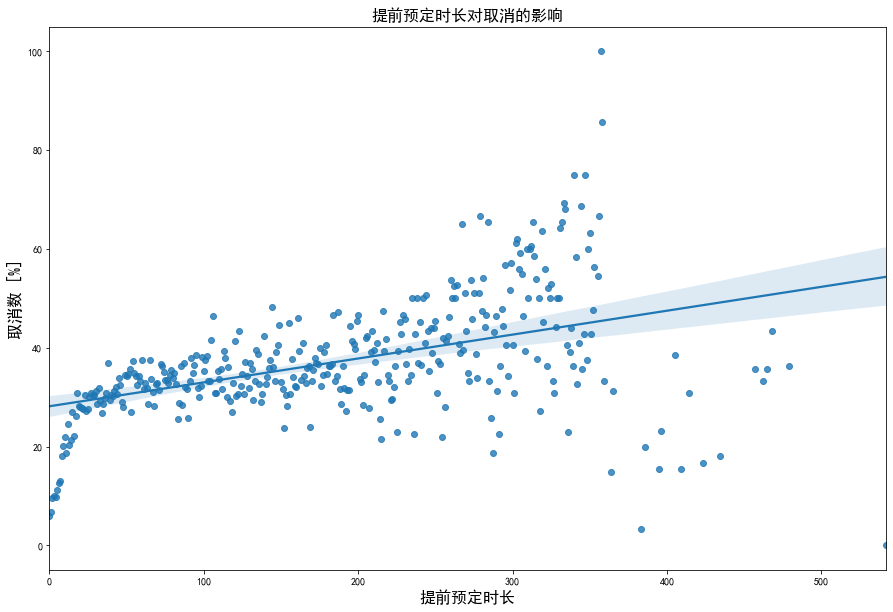

In [253]:
import seaborn as sns

# 提前预订时间与是否取消的关系
lead_cancel_data = pd.DataFrame(df.groupby("lead_time")["is_canceled"].describe())
# 因为lead_time中值范围大且数量分布不匀，所以选取lead_time>10次的数据（<10的数据不具代表性）
lead_cancel_data_10 = lead_cancel_data[lead_cancel_data["count"]>10]
y = list(round(lead_cancel_data_10["mean"], 4) * 100)
plt.figure(figsize=(15, 10))
sns.regplot(x=list(lead_cancel_data_10.index),
           y=y)
plt.title("提前预定时长对取消的影响", fontsize=16)
plt.xlabel("提前预定时长", fontsize=16)
plt.ylabel("取消数 [%]", fontsize=16)

探究提前预订时间与是否取消的关系,因为lead_time中值范围大且数量分布不匀，所以选取lead_time>10次的数据（<10的数据不具代表性）.
结果显示,用户提前预定时间越长,取消率越高.

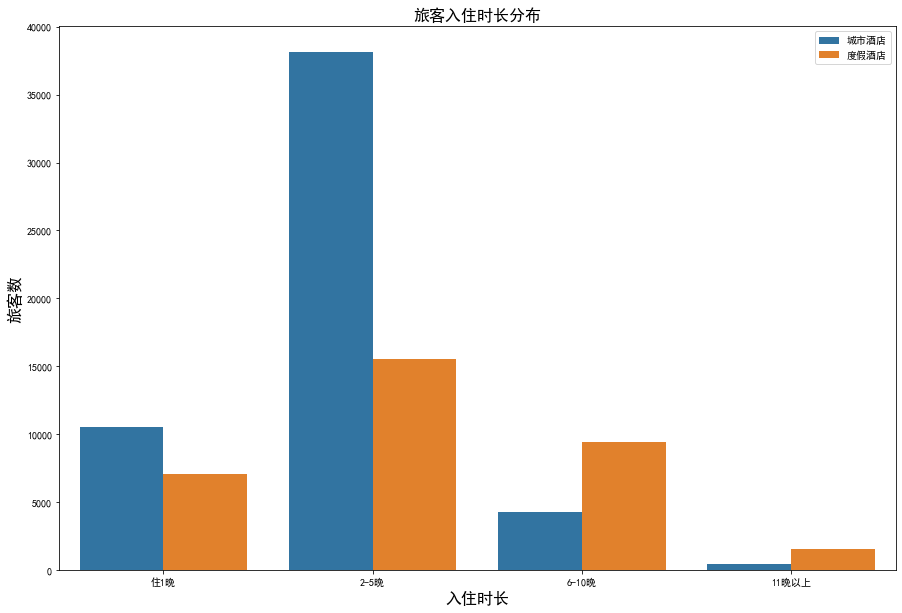

In [254]:
# 不同酒店类型与入住时长的关系
full_data_guests =df[['hotel','stays_in_weekend_nights','stays_in_week_nights']]
full_data_guests["total_nights"] = full_data_guests["stays_in_weekend_nights"] + full_data_guests["stays_in_week_nights"]

# 新建字段：total_nights_bin——居住时长区间
full_data_guests["total_nights_bin"] = "住1晚"
full_data_guests.loc[(full_data_guests["total_nights"]>1)&(full_data_guests["total_nights"]<=5), "total_nights_bin"] = "2-5晚"
full_data_guests.loc[(full_data_guests["total_nights"]>5)&(full_data_guests["total_nights"]<=10), "total_nights_bin"] = "6-10晚"
full_data_guests.loc[(full_data_guests["total_nights"]>10), "total_nights_bin"] = "11晚以上"

ch_nights_count = full_data_guests["total_nights_bin"][full_data_guests.hotel=="City Hotel"].value_counts()
rh_nights_count = full_data_guests["total_nights_bin"][full_data_guests.hotel=="Resort Hotel"].value_counts()

ch_nights_index = full_data_guests["total_nights_bin"][full_data_guests.hotel=="City Hotel"].value_counts().index
rh_nights_index = full_data_guests["total_nights_bin"][full_data_guests.hotel=="Resort Hotel"].value_counts().index

ch_nights_data = pd.DataFrame({"hotel": "城市酒店",
                               "nights": ch_nights_index,
                              "guests": ch_nights_count})
rh_nights_data = pd.DataFrame({"hotel": "度假酒店",
                               "nights": rh_nights_index,
                              "guests": rh_nights_count})

nights_data = pd.concat([ch_nights_data, rh_nights_data], ignore_index=True)
order = ["住1晚", "2-5晚", "6-10晚", "11晚以上"]
nights_data["nights"] = pd.Categorical(nights_data["nights"], categories=order, ordered=True)

plt.figure(figsize=(15, 10))
sns.barplot(x="nights", y="guests", hue="hotel", data=nights_data)
plt.title("旅客入住时长分布", fontsize=16)
plt.xlabel("入住时长", fontsize=16)
plt.ylabel("旅客数", fontsize=16)

plt.legend()

探究不同酒店类型与入住时长的关系,结果显示,城市酒店旅客入住时长分布不均匀,集中在1晚与2-5晚;度假酒店旅客入住时长分布较为均匀,住1晚,2-5晚,6-10晚均占一定比例.无论是城市酒店还是度假酒店,入住时长为2-5晚均占最大比例.

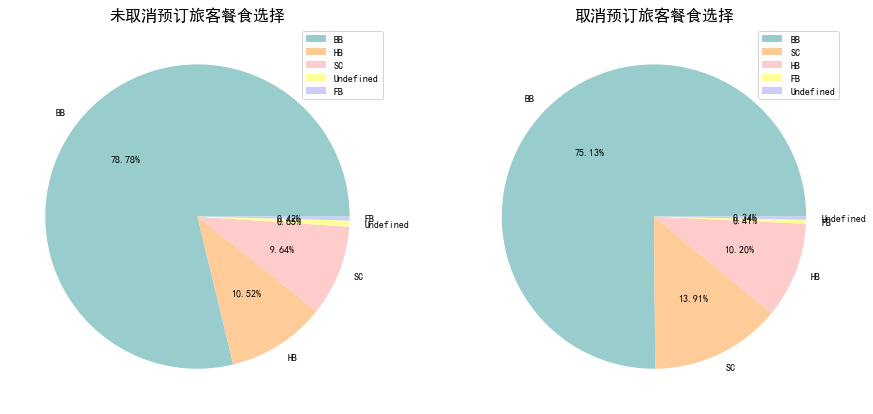

In [255]:
# 是否取消与餐食预定情况的关系
meal_data = df[["hotel", "is_canceled", "meal"]]

colors = ['#99CCCC', '#FFCC99', '#FFCCCC', '#FFFF99','#CCCCFF','#CCFFFF']

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.pie(meal_data.loc[meal_data["is_canceled"]==0, "meal"].value_counts(), colors=colors, 
        labels=meal_data.loc[meal_data["is_canceled"]==0, "meal"].value_counts().index, 
       autopct="%.2f%%")
plt.title("未取消预订旅客餐食选择", fontsize=16)
plt.legend(loc="upper right")

plt.subplot(122)
plt.pie(meal_data.loc[meal_data["is_canceled"]==1, "meal"].value_counts(), colors=colors, 
        labels=meal_data.loc[meal_data["is_canceled"]==1, "meal"].value_counts().index, 
       autopct="%.2f%%")
plt.title("取消预订旅客餐食选择", fontsize=16)
plt.legend(loc="upper right")

探究是否取消与餐食预定情况的关系.结果表明,取消预订旅客和未取消预订旅客有基本相同的餐食选择。我们不能因为一位游客bed&breakfast选择的是就说他一定会取消预定.

In [256]:
# 酒店分布地区
rh_country_count = df[df["hotel"]=="Resort Hotel"].groupby(["country"])["country"].count()
ch_country_count = df[df["hotel"]=="City Hotel"].groupby(["country"])["country"].count()

In [257]:
import pyecharts.options as opts
from pyecharts.charts import Line

country_name_list = rh_country_count.index.tolist()
rh_country = rh_country_count.values.tolist()
ch_country = ch_country_count.values.tolist()


(
    Line(init_opts=opts.InitOpts(width="1800px", height="900px"))
    .add_xaxis(xaxis_data=country_name_list)
    .add_yaxis(
        series_name="城市酒店City Hotel",
        y_axis=ch_country,
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
            ]
        ),
        markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(type_="average", name="平均值")]
        ),
    )
    .add_yaxis(
        series_name="度假酒店Resort Hotel",
        y_axis=rh_country,
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
            ]
        ),
        markline_opts=opts.MarkLineOpts(
            data=[
                opts.MarkLineItem(type_="average", name="平均值"),
                opts.MarkLineItem(symbol="none", x="90%", y="max"),
                opts.MarkLineItem(symbol="circle", type_="max", name="最高点"),
            ]
        ),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="不同国家酒店预订数对比"),
        tooltip_opts=opts.TooltipOpts(trigger="axis"),
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        xaxis_opts=opts.AxisOpts(type_="category", boundary_gap=False),
    )
    .render("country_change_line_chart.html")
)

'C:\\Users\\hespe\\Desktop\\课件\\数据挖掘\\country_change_line_chart.html'

由于 pyecharts 输出结果为HTML格式,为了方便分析,下面附上结果图截图:
![jupyter](./不同国家酒店预订数对比.PNG)
根据结果可以看出,度假酒店在PRG预订数最多,城市酒店在HKG预订数最多.

3. 一年中酒店最佳预定时间

Text(0, 0.5, '人均居住价格/晚')

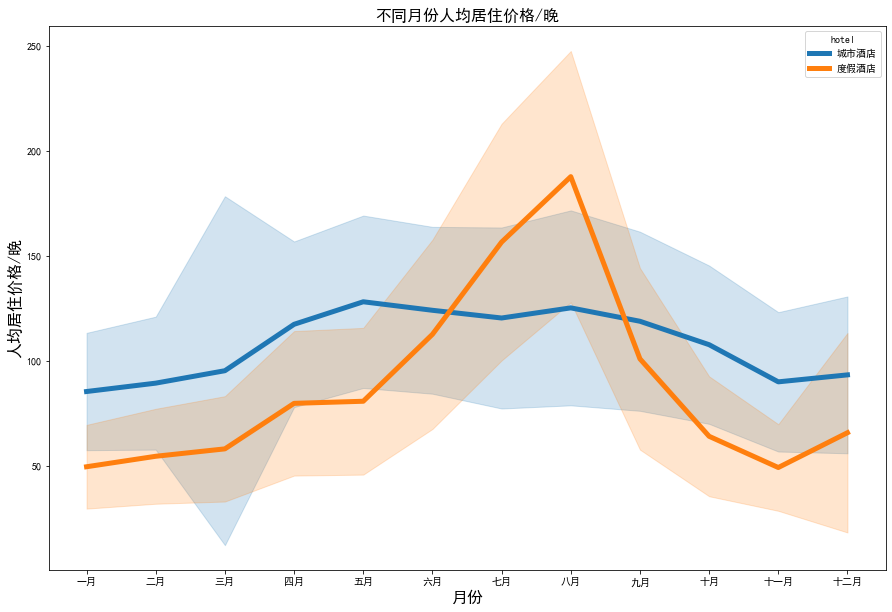

In [258]:
# 从月份上看人均平均每晚价格

room_price_monthly = df[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")

ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August",
                 "September", "October", "November", "December"]
month_che = ["一月", "二月", "三月", "四月", "五月", "六月", "七月", "八月", "九月", "十月", "十一月", "十二月", ]

for en, che in zip(ordered_months, month_che):
    room_price_monthly["arrival_date_month"].replace(en, che, inplace=True)
room_price_monthly["arrival_date_month"] = pd.Categorical(room_price_monthly["arrival_date_month"],
                                                         categories=month_che, ordered=True)
room_price_monthly["hotel"].replace("City Hotel", "城市酒店", inplace=True)
room_price_monthly["hotel"].replace("Resort Hotel", "度假酒店", inplace=True)
room_price_monthly.head(15)

plt.figure(figsize=(15, 10))
sns.lineplot(x="arrival_date_month", y="adr", hue="hotel", data=room_price_monthly,
            hue_order=["城市酒店", "度假酒店"], ci="sd", size="hotel", sizes=(5, 5))
plt.title("不同月份人均居住价格/晚", fontsize=16)
plt.xlabel("月份", fontsize=16)
plt.ylabel("人均居住价格/晚", fontsize=16)

根据不同月份的人均居住价格结果,酒店预订旺季为五月-十月,因此从经济角度考虑,一年中酒店预订最佳时间为十一月,其余一月,二月,三月也可以考虑.

4. 利用Logistic预测酒店预订-用户是否取消订单的概率

In [259]:
# 分析不同属性与是否取消预订之间的相关性
# 将非数字的属性进行编码

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_copy=df.copy()

month_map={'January':1,"February":2,"March":3,"April":4,"May":5,"June":6,"July":7,
           "August":8,"Septmber":9,"October":10,"November":11,"December":12}
data_copy.replace({"arrival_date_month":month_map},inplace=True)

data_copy['agent']= data_copy['agent'].astype(int)
data_copy['country']= data_copy['country'].astype(str)

data_copy['hotel'] = le.fit_transform(data_copy['hotel'])
data_copy['meal'] = le.fit_transform(data_copy['meal'])
data_copy['country'] = le.fit_transform(data_copy['country'])
data_copy['market_segment']= le.fit_transform(data_copy['market_segment'])
data_copy['distribution_channel']=le.fit_transform(data_copy['distribution_channel'])
data_copy['is_repeated_guest'] = le.fit_transform(data_copy['is_repeated_guest'])
data_copy['reserved_room_type'] = le.fit_transform(data_copy['reserved_room_type'])
data_copy['assigned_room_type'] = le.fit_transform(data_copy['assigned_room_type'])
data_copy['deposit_type'] = le.fit_transform(data_copy['deposit_type'])
data_copy['agent'] = le.fit_transform(data_copy['agent'])
data_copy['customer_type'] = le.fit_transform(data_copy['customer_type'])
data_copy['reservation_status'] = le.fit_transform(data_copy['reservation_status'])

# 计算spearman相关性系数,按结果从大到小输出
data_corr=data_copy.corr(method='spearman')
np.abs(data_corr['is_canceled']).sort_values(ascending=False)#降序

is_canceled                       1.000000
reservation_status                0.913905
lead_time                         0.224446
market_segment                    0.205334
required_car_parking_spaces       0.185859
deposit_type                      0.156113
distribution_channel              0.150440
adr                               0.140156
total_of_special_requests         0.129105
previous_cancellations            0.126221
booking_changes                   0.124381
previous_bookings_not_canceled    0.101031
stays_in_week_nights              0.094506
country                           0.092004
is_repeated_guest                 0.089283
adults                            0.087090
arrival_date_year                 0.086726
hotel                             0.069550
customer_type                     0.066825
assigned_room_type                0.063970
children                          0.060771
stays_in_weekend_nights           0.058679
reserved_room_type                0.045030
meal       

In [260]:
#分离训练集测试集
#取前一年半的数据作为训练集，后一年半的数据作为测试集
test = data_copy[(data_copy['arrival_date_year']==2015) | ((data_copy['arrival_date_year']==2016) & (data_copy['arrival_date_month'].isin(['January','February','March','April','May','June'])))]
train =  data_copy[(data_copy['arrival_date_year']==2017) | ((data_copy['arrival_date_year']==2016) & (~data_copy['arrival_date_month'].isin(['January','February','March','April','May','June'])))]

d1 = train.groupby('is_canceled').count().iloc[:,0]
d2 = test.groupby('is_canceled').count().iloc[:,0]
print('train:',train.shape,'\ncanceled_rate:',round(d1[1]/(d1[0]+d1[1]),2))
print('test:',test.shape,'\ncanceled_rate:',round(d2[1]/(d2[0]+d2[1]),2))

train: (73608, 32) 
canceled_rate: 0.29
test: (13175, 32) 
canceled_rate: 0.2


reservation_status是最终入住状态,这与是否取消其实是一致的.除此之外,考虑相关性系数>0.15的几种属性:lead_time,market_segment, required_car_parking_spaces,
deposit_type,
distribution_channel

In [261]:
corr_list=["is_canceled","lead_time","market_segment","required_car_parking_spaces", "deposit_type", "distribution_channel"]
train_new = train[corr_list]
test_new = test[corr_list]
# 输出训练集的前几行数据
train_new.head()

,is_canceled,lead_time,market_segment,required_car_parking_spaces,deposit_type,distribution_channel
3738,0,109,6,0,0,3
3739,0,109,6,1,0,3
3740,1,2,6,0,0,3
3741,0,88,6,0,0,3
3742,1,20,6,0,0,3


In [262]:
train_x=train_new.drop(["is_canceled"],axis=1)
train_y=train_new.loc[:,"is_canceled"]
test_x=test_new.drop(["is_canceled"],axis=1)
test_y=test_new.loc[:,"is_canceled"]

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(train_x,train_y) #训练模型
y_predict = LR.predict(test_x)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y,y_predict)
print(accuracy)

0.8079696394686907


结果显示,根据提取的特征向量,logistics预测用户取消预订准确率可达80.80%.